In [6]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from haversine import haversine
import matplotlib.pyplot as plt
import seaborn as sns
import time

def load_data(file_path):
    """
    Laad de dataset uit het opgegeven CSV-bestand
    """
    start_time = time.time()
    print("Data laden wordt gestart...")
    
    df = pd.read_csv(file_path)
    print(f"Dataset geladen: {df.shape[0]} rijen en {df.shape[1]} kolommen")
    
    # Converteer datumkolom naar datetime
    if 'date' in df.columns:
        print("Converteren van datums naar datetime formaat...")
        df['date'] = pd.to_datetime(df['date'])
    
    # Zorg ervoor dat de prijs numeriek is
    if 'price' in df.columns and df['price'].dtype == 'object':
        print("Converteren van prijzen naar numerieke waarden...")
        df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)
    
    elapsed_time = time.time() - start_time
    print(f"Data laden voltooid in {elapsed_time:.2f} seconden")
    return df

def get_feature_columns(df):
    """
    Identificeer en selecteer de feature kolommen voor similarity berekening
    """
    # --- START: Feature detectie ---
    print("Detecteren van bruikbare features...")
    # We zoeken automatisch naar relevante features in de dataset
    numeric_features = []
    binary_features = []
    
    # Zoek naar numerieke features zoals accommodates, bedrooms, bathrooms
    potential_numeric = ['accommodates', 'bedrooms', 'bathrooms']
    for feature in potential_numeric:
        if feature in df.columns and pd.api.types.is_numeric_dtype(df[feature]):
            numeric_features.append(feature)
    
    # Zoek naar binaire features (voorzieningen) die beginnen met 'has_'
    for col in df.columns:
        if col.startswith('has_') and pd.api.types.is_numeric_dtype(df[col]):
            binary_features.append(col)
    
    # Controleer of neighbourhood informatie beschikbaar is
    neighbourhood_feature = None
    if 'neighbourhood_cleansed_encoded' in df.columns:
        neighbourhood_feature = 'neighbourhood_cleansed_encoded'
    
    print(f"Feature detectie voltooid. Gevonden: {len(numeric_features)} numerieke, {len(binary_features)} binaire features")
    # --- EINDE: Feature detectie ---
    
    return numeric_features, binary_features, neighbourhood_feature

def calculate_hybrid_distances(df, sample_listings, n_neighbors=10, feature_weight=0.5):
    """
    Bereken een hybride afstandsmatrix op basis van zowel geografische locatie als listing features
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset met listings en features
    sample_listings : list
        Lijst met listing IDs waarvoor we neighbours willen vinden
    n_neighbors : int
        Aantal buren om te vinden
    feature_weight : float (0-1)
        Gewicht voor feature afstanden t.o.v. geografische afstanden (0 = alleen geografisch, 1 = alleen features)
        
    Returns:
    --------
    tuple
        (neighbor_indices, neighbor_distances, similarity_scores)
        voor elke listing in sample_listings
    """
    start_time = time.time()
    # --- START: Voorbereiden van listing features ---
    print("Voorbereiden van listing features...")
    # Selecteer unieke listings (één rij per listing)
    listing_features = df.drop_duplicates('listing_id')
    
    # Detecteer automatisch relevante feature kolommen
    numeric_features, binary_features, neighbourhood_feature = get_feature_columns(listing_features)
    
    print(f"Gebruikte numerieke features: {numeric_features}")
    print(f"Gebruikte binaire features: {binary_features}")
    print(f"Gebruikte neighbourhood feature: {neighbourhood_feature}")
    
    # Combineer alle relevante features
    feature_cols = numeric_features + binary_features
    if neighbourhood_feature:
        feature_cols.append(neighbourhood_feature)
    
    # Controleer of er voldoende features zijn
    if len(feature_cols) < 2:
        print("Waarschuwing: Onvoldoende features beschikbaar, valt terug op alleen geografische afstand")
        feature_weight = 0
    # --- EINDE: Voorbereiden van listing features ---
    
    feature_prep_time = time.time() - start_time
    print(f"Feature voorbereiden voltooid in {feature_prep_time:.2f} seconden")
    
    # --- START: Berekenen van geografische afstanden ---
    geo_start_time = time.time()
    print("Berekenen van geografische afstanden...")
    all_listings = listing_features['listing_id'].values
    coords = listing_features[['latitude', 'longitude']].values
    
    geo_distances = np.zeros((len(sample_listings), len(all_listings)))
    
    for i, listing_id in enumerate(sample_listings):
        # Voortgang tonen
        if i % 100 == 0 and i > 0:
            elapsed = time.time() - geo_start_time
            remaining = (elapsed / i) * (len(sample_listings) - i)
            print(f"  Geografische afstanden: {i}/{len(sample_listings)} listings verwerkt ({i/len(sample_listings)*100:.1f}%). Geschatte resterende tijd: {remaining/60:.1f} minuten")
            
        # Vind index van deze listing
        list_idx = np.where(all_listings == listing_id)[0][0]
        # Geografische coördinaten van deze listing
        lat1, lon1 = coords[list_idx]
        
        # Bereken afstand tot alle andere listings (in km)
        for j, (lat2, lon2) in enumerate(coords):
            geo_distances[i, j] = haversine((lat1, lon1), (lat2, lon2))
    
    # Normaliseer geografische afstanden (schaal 0-1)
    geo_max = np.max(geo_distances)
    if geo_max > 0:
        geo_distances = geo_distances / geo_max
        print(f"Geografische afstanden genormaliseerd (max afstand: {geo_max:.2f} km)")
    
    geo_time = time.time() - geo_start_time
    print(f"Geografische afstandsberekening voltooid in {geo_time:.2f} seconden")
    # --- EINDE: Berekenen van geografische afstanden ---
    
    # --- START: Berekenen van feature afstanden (indien feature_weight > 0) ---
    if feature_weight > 0 and feature_cols:
        feat_start_time = time.time()
        print("Berekenen van feature afstanden...")
        # Bereid features voor
        X = listing_features[feature_cols].values
        
        # Normaliseer features met StandardScaler (voor betere vergelijking)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        print(f"Features genormaliseerd met StandardScaler")
        
        # Bereken feature afstanden
        feature_distances = np.zeros((len(sample_listings), len(all_listings)))
        
        for i, listing_id in enumerate(sample_listings):
            # Voortgang tonen
            if i % 100 == 0 and i > 0:
                elapsed = time.time() - feat_start_time
                remaining = (elapsed / i) * (len(sample_listings) - i)
                print(f"  Feature afstanden: {i}/{len(sample_listings)} listings verwerkt ({i/len(sample_listings)*100:.1f}%). Geschatte resterende tijd: {remaining/60:.1f} minuten")
                
            # Vind index van deze listing
            list_idx = np.where(all_listings == listing_id)[0][0]
            # Features van deze listing
            feat1 = X_scaled[list_idx]
            
            # Bereken Euclidische afstand tot alle andere listings
            for j, feat2 in enumerate(X_scaled):
                feature_distances[i, j] = np.sqrt(np.sum((feat1 - feat2) ** 2))
        
        # Normaliseer feature afstanden (schaal 0-1)
        feat_max = np.max(feature_distances)
        if feat_max > 0:
            feature_distances = feature_distances / feat_max
            print(f"Feature afstanden genormaliseerd (max afstand: {feat_max:.2f})")
        
        # Combineer geografische en feature afstanden met gewogen gemiddelde
        print(f"Combineren van afstanden met feature_weight={feature_weight:.2f}...")
        hybrid_distances = (1 - feature_weight) * geo_distances + feature_weight * feature_distances
        print(f"Hybride afstanden berekend: {1-feature_weight:.2f} * geo + {feature_weight:.2f} * features")
        
        feat_time = time.time() - feat_start_time
        print(f"Feature afstandsberekening voltooid in {feat_time:.2f} seconden")
    else:
        # Gebruik alleen geografische afstanden
        print("Alleen geografische afstanden worden gebruikt (feature_weight=0)")
        hybrid_distances = geo_distances
    # --- EINDE: Berekenen van feature afstanden ---
    
    # --- START: Vinden van dichtstbijzijnde buren ---
    neighbor_start_time = time.time()
    print(f"Vinden van {n_neighbors} dichtstbijzijnde buren voor elke listing...")
    # Resultaten voor elke listing
    neighbor_indices = []
    neighbor_distances = []
    similarity_scores = []
    
    # Voor elke listing, vind de n dichtstbijzijnde buren
    for i, listing_id in enumerate(sample_listings):
        # Voortgang tonen voor grote datasets
        if i % 1000 == 0 and i > 0:
            print(f"  Buren zoeken: {i}/{len(sample_listings)} listings verwerkt ({i/len(sample_listings)*100:.1f}%)")
            
        # Vind index van deze listing
        list_idx = np.where(all_listings == listing_id)[0][0]
        
        # Afstanden tot alle andere listings
        distances = hybrid_distances[i]
        
        # Zet eigen afstand op inf om deze uit te sluiten
        distances[list_idx] = np.inf
        
        # Vind indices van n dichtstbijzijnde buren
        idx = np.argsort(distances)[:n_neighbors]
        
        # Sla indices, afstanden en similariteiten op
        neighbor_indices.append(idx)
        neighbor_distances.append(distances[idx])
        similarity_scores.append(1 - distances[idx])  # Converteer afstand naar similariteit
    
    neighbor_time = time.time() - neighbor_start_time
    print(f"Buren gevonden voor alle {len(sample_listings)} listings in {neighbor_time:.2f} seconden")
    # --- EINDE: Vinden van dichtstbijzijnde buren ---
    
    total_time = time.time() - start_time
    print(f"Totale tijd voor afstandsberekening en buur-selectie: {total_time:.2f} seconden")
    
    return all_listings, neighbor_indices, neighbor_distances, similarity_scores

def create_simulated_prices_hybrid(df, n_neighbors=5, feature_weight=0.5, sigma=1.0):
    """
    Creëer gesimuleerde prijzen voor alle listings met een hybride KNN-benadering
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset met listings, datums en prijzen
    n_neighbors : int
        Aantal buren om te gebruiken
    feature_weight : float (0-1)
        Gewicht voor feature similariteit vs. geografische nabijheid
    sigma : float
        Parameter voor de Gaussian kernel bij het berekenen van gewichten
    """
    start_time = time.time()
    # --- START: Voorbereiden van data ---
    # Unieke listings en datums
    unique_listings = df['listing_id'].unique()
    unique_dates = sorted(df['date'].unique())
    
    print(f"Aantal unieke listings in dataset: {len(unique_listings)}")
    print(f"Aantal unieke datums: {len(unique_dates)}")
    
    # Selecteer alle listings met voldoende datapunten
    print("Controleren van listings met voldoende datapunten...")
    listing_counts = df.groupby('listing_id').size()
    eligible_listings = listing_counts[listing_counts >= 2].index.tolist()
    
    print(f"Aantal bruikbare listings: {len(eligible_listings)} van {len(unique_listings)}")
    
    # We gebruiken alle bruikbare listings
    sample_listings = eligible_listings
    
    # Maak een pivot tabel: listings als rijen, datums als kolommen, prijs als waarde
    print("Maken van pivot tabel met prijzen...")
    price_pivot = df.pivot_table(index='listing_id', columns='date', values='price')
    # --- EINDE: Voorbereiden van data ---
    
    # --- START: Berekenen van hybride afstanden en vinden van buren ---
    print(f"Berekenen van hybride afstanden met feature_weight={feature_weight}...")
    all_listings, neighbor_indices_list, neighbor_distances_list, similarity_scores_list = \
        calculate_hybrid_distances(df, sample_listings, n_neighbors=n_neighbors, feature_weight=feature_weight)
    # --- EINDE: Berekenen van hybride afstanden en vinden van buren ---
    
    # --- START: Genereren van gesimuleerde prijzen ---
    sim_start_time = time.time()
    print("Genereren van gesimuleerde prijzen...")
    # Creëer een dataframe voor gesimuleerde prijzen
    simulated_prices = []
    
    # Voor elke listing
    total_listings = len(sample_listings)
    for i, listing_id in enumerate(sample_listings):
        # Voortgang tonen met percentage
        if i % 100 == 0 or i == total_listings - 1:
            percentage = (i + 1) / total_listings * 100
            elapsed = time.time() - sim_start_time
            if i > 0:
                estimated_remaining = (elapsed / i) * (total_listings - i)
                print(f"  Voortgang: {i+1}/{total_listings} listings ({percentage:.1f}%). Geschatte tijd nog: {estimated_remaining/60:.1f} minuten")
            else:
                print(f"  Voortgang: {i+1}/{total_listings} listings ({percentage:.1f}%)")
            
        # Indices van buren
        neighbor_idx = neighbor_indices_list[i]
        # Similariteitsscores van buren (1 = identiek, 0 = volledig verschillend)
        similarity = similarity_scores_list[i]
        
        # Converteer indexen naar listing IDs
        neighbor_ids = [all_listings[idx] for idx in neighbor_idx]
        
        # Bereken gewichten met Gaussian kernel
        # De formule is: exp(-(1-sim)²/(2*sigma²))
        # Dit geeft hogere gewichten aan meer vergelijkbare listings
        weights = np.exp(-(1 - similarity) ** 2 / (2 * sigma ** 2))
        weights = weights / np.sum(weights)  # Normaliseer zodat som = 1
        
        # Sla buurinformatie alleen op voor de eerste 20 listings (als voorbeeld)
        if i < 20:
            print(f"Listing {listing_id} heeft als buren: {neighbor_ids}")
            print(f"Similariteitsscores: {similarity.round(3)}")
            print(f"Gewichten: {weights.round(3)}")
        
        # Voor elke datum, bereken een gesimuleerde prijs
        n_dates_processed = 0
        for date in unique_dates:
            # Skip indien deze datum niet in de pivot tabel staat
            if date not in price_pivot.columns:
                continue
                
            # Haal prijzen van buren voor deze datum op
            neighbor_prices = []
            valid_weights = []
            valid_neighbor_ids = []
            
            for j, n_id in enumerate(neighbor_ids):
                if n_id in price_pivot.index and date in price_pivot.columns and not pd.isna(price_pivot.loc[n_id, date]):
                    neighbor_prices.append(price_pivot.loc[n_id, date])
                    valid_weights.append(weights[j])
                    valid_neighbor_ids.append(n_id)
            
            # Skip indien geen buren met geldige prijzen voor deze datum
            if not neighbor_prices:
                continue
                
            # Normaliseer de gewichten voor de geldige buren
            valid_weights = np.array(valid_weights)
            valid_weights = valid_weights / valid_weights.sum()
            
            # Bereken gesimuleerde prijs als gewogen gemiddelde
            simulated_price = np.average(neighbor_prices, weights=valid_weights)
            
            # Haal originele prijs op (indien beschikbaar)
            if listing_id in price_pivot.index and not pd.isna(price_pivot.loc[listing_id, date]):
                original_price = price_pivot.loc[listing_id, date]
            else:
                original_price = np.nan
            
            # Voeg toe aan resultaten
            simulated_prices.append({
                'listing_id': listing_id,
                'date': date,
                'original_price': original_price,
                'simulated_price': simulated_price,
                'num_neighbors_used': len(neighbor_prices),
                'neighbors_used': ','.join(map(str, valid_neighbor_ids))
            })
            
            n_dates_processed += 1
        
        # Sla het aantal verwerkte datums alleen op voor de eerste 20 listings
        if i < 20:
            print(f"  → {n_dates_processed} datums verwerkt voor listing {listing_id}")
    
    # Converteer naar DataFrame
    simulated_df = pd.DataFrame(simulated_prices)
    print(f"Totaal aantal gesimuleerde prijzen: {len(simulated_df)}")
    
    sim_time = time.time() - sim_start_time
    print(f"Genereren van gesimuleerde prijzen voltooid in {sim_time:.2f} seconden")
    # --- EINDE: Genereren van gesimuleerde prijzen ---
    
    # --- START: Evaluatie van de simulatie ---
    # Verwijder rijen waar original_price NaN is (voor evaluatie)
    evaluation_df = simulated_df.dropna(subset=['original_price'])
    print(f"Aantal prijzen beschikbaar voor evaluatie: {len(evaluation_df)}")
    
    # Evalueer de kwaliteit van de simulatie
    if len(evaluation_df) > 0:
        eval_start_time = time.time()
        print("Evalueren van simulatie kwaliteit...")
        
        mae = mean_absolute_error(evaluation_df['original_price'], evaluation_df['simulated_price'])
        rmse = np.sqrt(mean_squared_error(evaluation_df['original_price'], evaluation_df['simulated_price']))
        r2 = r2_score(evaluation_df['original_price'], evaluation_df['simulated_price'])
        
        print(f"\nEvaluatie van gesimuleerde prijzen:")
        print(f"MAE: {mae:.2f} (lager is beter)")
        print(f"RMSE: {rmse:.2f} (lager is beter)")
        print(f"R²: {r2:.4f} (hoger is beter)")
        
        eval_time = time.time() - eval_start_time
        print(f"Evaluatie voltooid in {eval_time:.2f} seconden")
    else:
        print("Geen data beschikbaar voor evaluatie.")
    # --- EINDE: Evaluatie van de simulatie ---
    
    total_time = time.time() - start_time
    print(f"Totale tijd voor prijssimulatie: {total_time:.2f} seconden ({total_time/60:.2f} minuten)")
    
    return simulated_df

def compare_feature_weights(df, sample_size=100, n_neighbors=5):
    """
    Vergelijk verschillende feature gewichten en hun effect op de prestaties
    
    Gebruikt een steekproef van listings om de optimale feature_weight te bepalen
    """
    # --- START: Voorbereiden van test listings ---
    start_time = time.time()
    print(f"Selecteren van {sample_size} listings voor feature weight vergelijking...")
    # Selecteer een steekproef van listings
    listing_counts = df.groupby('listing_id').size()
    eligible_listings = listing_counts[listing_counts >= 5].index.tolist()
    
    if len(eligible_listings) < sample_size:
        print(f"Waarschuwing: Slechts {len(eligible_listings)} listings hebben voldoende datapunten.")
        sample_size = min(sample_size, len(eligible_listings))
    
    # Zet een specifieke random seed voor reproduceerbaarheid
    np.random.seed(42)
    sample_listings = np.random.choice(eligible_listings, size=sample_size, replace=False)
    print(f"Geselecteerde {len(sample_listings)} sample listings voor vergelijking")
    # --- EINDE: Voorbereiden van test listings ---
    
    # --- START: Testen van verschillende feature weights ---
    print("Starten met testen van verschillende feature weights...")
    # Probeer verschillende feature gewichten
    feature_weights = [0.0, 0.25, 0.5, 0.75, 1.0]
    results = []
    
    for fw in feature_weights:
        fw_start_time = time.time()
        print(f"\n============ Testen met feature_weight = {fw} ============")
        
        # Creëer gesimuleerde prijzen met dit gewicht
        simulated_df = create_simulated_prices_hybrid(
            df.query(f"listing_id in {sample_listings.tolist()}"),  # Gebruik alleen de geselecteerde listings
            n_neighbors=n_neighbors, 
            feature_weight=fw, 
            sigma=1.0
        )
        
        # Evalueer
        eval_df = simulated_df.dropna(subset=['original_price'])
        
        if len(eval_df) > 0:
            mae = mean_absolute_error(eval_df['original_price'], eval_df['simulated_price'])
            rmse = np.sqrt(mean_squared_error(eval_df['original_price'], eval_df['simulated_price']))
            r2 = r2_score(eval_df['original_price'], eval_df['simulated_price'])
            
            results.append({
                'feature_weight': fw,
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2
            })
            
            print(f"Resultaten voor feature_weight = {fw}:")
            print(f"  MAE: {mae:.2f}")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  R²: {r2:.4f}")
            
            fw_time = time.time() - fw_start_time
            print(f"Test voor feature_weight = {fw} voltooid in {fw_time:.2f} seconden")
    # --- EINDE: Testen van verschillende feature weights ---
    
    # --- START: Visualiseren en analyseren van resultaten ---
    # Maak vergelijkingsplot
    results_df = pd.DataFrame(results)
    
    if len(results_df) > 0:
        print("\nMaken van vergelijkingsplot voor verschillende feature weights...")
        plt.figure(figsize=(12, 8))
        
        # Plot MAE
        plt.subplot(1, 2, 1)
        plt.plot(results_df['feature_weight'], results_df['MAE'], 'o-', color='blue', linewidth=2)
        plt.title('Effect van Feature Weight op MAE')
        plt.xlabel('Feature Weight')
        plt.ylabel('Mean Absolute Error')
        plt.grid(True, alpha=0.3)
        
        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(results_df['feature_weight'], results_df['R2'], 'o-', color='green', linewidth=2)
        plt.title('Effect van Feature Weight op R²')
        plt.xlabel('Feature Weight')
        plt.ylabel('R² Score')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('feature_weight_comparison.png')
        plt.show()
        
        # Print beste feature weight
        best_idx = results_df['MAE'].idxmin()
        best_fw = results_df.loc[best_idx, 'feature_weight']
        best_mae = results_df.loc[best_idx, 'MAE']
        
        print(f"\nBeste feature weight: {best_fw} (MAE: {best_mae:.2f})")
        print("\nResultaten per feature weight:")
        print(results_df)
        
        total_time = time.time() - start_time
        print(f"Totale tijd voor feature weight vergelijking: {total_time:.2f} seconden ({total_time/60:.2f} minuten)")
        
        return best_fw
    else:
        print("Onvoldoende data voor vergelijking")
        total_time = time.time() - start_time
        print(f"Totale tijd voor feature weight vergelijking: {total_time:.2f} seconden")
        return 0.5
    # --- EINDE: Visualiseren en analyseren van resultaten ---

def main():
    # --- START: Setup ---
    overall_start_time = time.time()
    # Pad naar trainingsbestand
    file_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\train.csv"
    
    # Laad de data
    print("\n=========== Start van prijssimulatie met hybride KNN voor volledige dataset ===========")
    print("Data laden...")
    df = load_data(file_path)
    # --- EINDE: Setup ---
    
    # --- START: Feature weight optimalisatie met een steekproef ---
    print("\n=========== Zoeken naar optimale feature weight met steekproef van 100 listings ===========")
    # Gebruik een grotere steekproef (100) voor betrouwbaardere resultaten
    best_fw = compare_feature_weights(df, sample_size=100, n_neighbors=5)
    # --- EINDE: Feature weight optimalisatie ---
    
    # --- START: Prijssimulatie voor de volledige dataset ---
    print(f"\n=========== Simulatie voor de volledige dataset met feature weight: {best_fw} ===========")
    # Verwerk de volledige dataset
    simulated_df = create_simulated_prices_hybrid(df, n_neighbors=5, feature_weight=best_fw)
    
    # Sla de gesimuleerde prijzen op
    output_file = 'all_listings_simulated_prices.csv'
    simulated_df.to_csv(output_file, index=False)
    print(f"\nGesimuleerde prijzen opgeslagen in '{output_file}'")
    # --- EINDE: Prijssimulatie voor de volledige dataset ---
    
    overall_time = time.time() - overall_start_time
    minutes = overall_time // 60
    seconds = overall_time % 60
    
    print("\n=========== Analyse voltooid! ===========")
    print(f"Totale uitvoeringstijd: {minutes:.0f} minuten en {seconds:.0f} seconden")
    print(f"Je kunt de gesimuleerde prijzen vinden in het bestand '{output_file}'")
    print("Dit CSV-bestand bevat de kolommen:")
    print("  - listing_id: ID van de listing")
    print("  - date: datum van de waarneming")
    print("  - original_price: oorspronkelijke prijs")
    print("  - simulated_price: gesimuleerde prijs")
    print("  - num_neighbors_used: aantal buren gebruikt voor deze voorspelling")
    print("  - neighbors_used: listing IDs van de gebruikte buren")
    print("\nOm deze gesimuleerde prijzen aan je originele dataset toe te voegen, kun je dit doen:")
    print("  1. Laad je originele dataset")
    print("  2. Laad het CSV-bestand met gesimuleerde prijzen")
    print("  3. Voer een merge uit op 'listing_id' en 'date'")
    print("  4. Maak een kolom met de originele prijs of de gesimuleerde prijs, afhankelijk van wat je wilt testen")

if __name__ == "__main__":
    main()


=========== Start van prijssimulatie met hybride KNN voor volledige dataset ===========
Data laden...
Data laden wordt gestart...
Dataset geladen: 1640389 rijen en 46 kolommen
Converteren van datums naar datetime formaat...
Data laden voltooid in 5.27 seconden

=========== Zoeken naar optimale feature weight met steekproef van 100 listings ===========
Selecteren van 100 listings voor feature weight vergelijking...
Geselecteerde 100 sample listings voor vergelijking
Starten met testen van verschillende feature weights...

============ Testen met feature_weight = 0.0 ============
Aantal unieke listings in dataset: 100
Aantal unieke datums: 216
Controleren van listings met voldoende datapunten...
Aantal bruikbare listings: 100 van 100
Maken van pivot tabel met prijzen...
Berekenen van hybride afstanden met feature_weight=0.0...
Voorbereiden van listing features...
Detecteren van bruikbare features...
Feature detectie voltooid. Gevonden: 3 numerieke, 20 binaire features
Gebruikte numeriek

KeyboardInterrupt: 


=========== Start van prijssimulatie met hybride KNN voor volledige dataset ===========
Data laden...
Data laden wordt gestart...
Dataset geladen: 1640389 rijen en 46 kolommen
Converteren van datums naar datetime formaat...
Data laden voltooid in 5.67 seconden

=========== Zoeken naar optimale feature weight met steekproef van 100 listings ===========
Selecteren van 100 listings voor feature weight vergelijking...
Geselecteerde 100 sample listings voor vergelijking
Starten met testen van verschillende feature weights...

============ Testen met feature_weight = 0.0 ============
Aantal unieke listings in dataset: 100
Aantal unieke datums: 216
Controleren van listings met voldoende datapunten...
Aantal bruikbare listings: 100 van 100
Maken van pivot tabel met prijzen...
Berekenen van hybride afstanden met feature_weight=0.0...
Voorbereiden van listing features...
Geladen 6291 listings uit train_ids.txt
Aantal listings beschikbaar als potentiële buren: 72
Detecteren van bruikbare feature

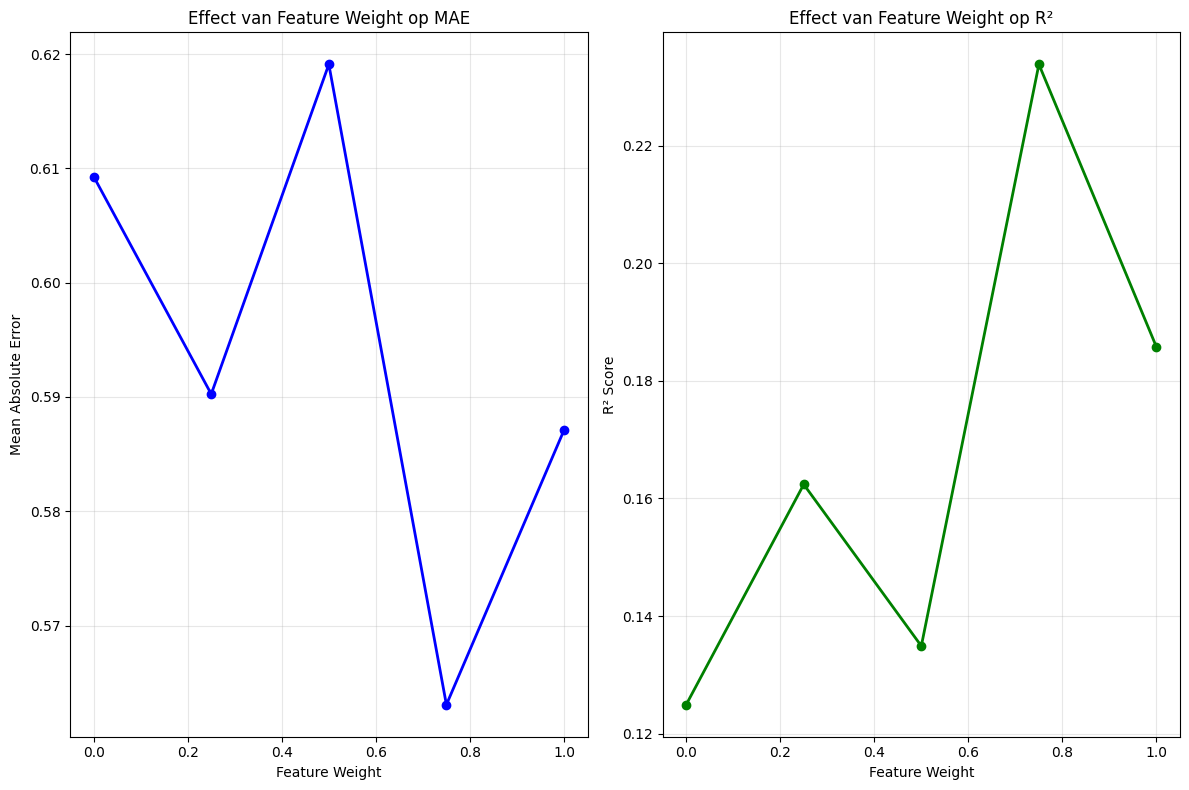


Beste feature weight: 0.75 (MAE: 0.56)

Resultaten per feature weight:
   feature_weight       MAE      RMSE        R2
0            0.00  0.609297  0.948631  0.124920
1            0.25  0.590252  0.928097  0.162394
2            0.50  0.619112  0.943204  0.134905
3            0.75  0.563070  0.887629  0.233847
4            1.00  0.587091  0.915065  0.185751
Totale tijd voor feature weight vergelijking: 11.55 seconden (0.19 minuten)

=========== Simulatie voor de volledige dataset met feature weight: 0.75 ===========
Aantal unieke listings in dataset: 7864
Aantal unieke datums: 216
Controleren van listings met voldoende datapunten...
Aantal bruikbare listings: 7864 van 7864
Maken van pivot tabel met prijzen...
Berekenen van hybride afstanden met feature_weight=0.75...
Voorbereiden van listing features...
Geladen 6291 listings uit train_ids.txt
Aantal listings beschikbaar als potentiële buren: 6291
Detecteren van bruikbare features...
Feature detectie voltooid. Gevonden: 3 numerieke, 20 

In [7]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from haversine import haversine
import matplotlib.pyplot as plt
import seaborn as sns
import time

def load_data(file_path):
    """
    Laad de dataset uit het opgegeven CSV-bestand
    """
    start_time = time.time()
    print("Data laden wordt gestart...")
    
    df = pd.read_csv(file_path)
    print(f"Dataset geladen: {df.shape[0]} rijen en {df.shape[1]} kolommen")
    
    # Converteer datumkolom naar datetime
    if 'date' in df.columns:
        print("Converteren van datums naar datetime formaat...")
        df['date'] = pd.to_datetime(df['date'])
    
    # Zorg ervoor dat de prijs numeriek is
    if 'price' in df.columns and df['price'].dtype == 'object':
        print("Converteren van prijzen naar numerieke waarden...")
        df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)
    
    elapsed_time = time.time() - start_time
    print(f"Data laden voltooid in {elapsed_time:.2f} seconden")
    return df

def get_feature_columns(df):
    """
    Identificeer en selecteer de feature kolommen voor similarity berekening
    """
    # --- START: Feature detectie ---
    print("Detecteren van bruikbare features...")
    # We zoeken automatisch naar relevante features in de dataset
    numeric_features = []
    binary_features = []
    
    # Zoek naar numerieke features zoals accommodates, bedrooms, bathrooms
    potential_numeric = ['accommodates', 'bedrooms', 'bathrooms']
    for feature in potential_numeric:
        if feature in df.columns and pd.api.types.is_numeric_dtype(df[feature]):
            numeric_features.append(feature)
    
    # Zoek naar binaire features (voorzieningen) die beginnen met 'has_'
    for col in df.columns:
        if col.startswith('has_') and pd.api.types.is_numeric_dtype(df[col]):
            binary_features.append(col)
    
    # Controleer of neighbourhood informatie beschikbaar is
    neighbourhood_feature = None
    if 'neighbourhood_cleansed_encoded' in df.columns:
        neighbourhood_feature = 'neighbourhood_cleansed_encoded'
    
    print(f"Feature detectie voltooid. Gevonden: {len(numeric_features)} numerieke, {len(binary_features)} binaire features")
    # --- EINDE: Feature detectie ---
    
    return numeric_features, binary_features, neighbourhood_feature

def calculate_hybrid_distances(df, sample_listings, n_neighbors=10, feature_weight=0.5):
    """
    Bereken een hybride afstandsmatrix op basis van zowel geografische locatie als listing features
    Gebruik alleen listings uit train_ids.txt als potentiële buren
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset met listings en features
    sample_listings : list
        Lijst met listing IDs waarvoor we neighbours willen vinden
    n_neighbors : int
        Aantal buren om te vinden
    feature_weight : float (0-1)
        Gewicht voor feature afstanden t.o.v. geografische afstanden (0 = alleen geografisch, 1 = alleen features)
        
    Returns:
    --------
    tuple
        (neighbor_indices, neighbor_distances, similarity_scores)
        voor elke listing in sample_listings
    """
    start_time = time.time()
    # --- START: Voorbereiden van listing features ---
    print("Voorbereiden van listing features...")
    # Selecteer unieke listings (één rij per listing)
    listing_features = df.drop_duplicates('listing_id')
    
    # Laad training listing IDs
    try:
        with open('train_ids.txt', 'r') as f:
            train_listings = [int(line.strip()) for line in f.readlines()]
        print(f"Geladen {len(train_listings)} listings uit train_ids.txt")
    except:
        print("Waarschuwing: Kan train_ids.txt niet laden, gebruik alle listings als potentiële buren")
        train_listings = listing_features['listing_id'].tolist()
    
    # Filter voor potential neighbors (alleen trainingslistings)
    neighbor_features = listing_features[listing_features['listing_id'].isin(train_listings)]
    print(f"Aantal listings beschikbaar als potentiële buren: {len(neighbor_features)}")
    
    # Detecteer automatisch relevante feature kolommen
    numeric_features, binary_features, neighbourhood_feature = get_feature_columns(listing_features)
    
    print(f"Gebruikte numerieke features: {numeric_features}")
    print(f"Gebruikte binaire features: {binary_features}")
    print(f"Gebruikte neighbourhood feature: {neighbourhood_feature}")
    
    # Combineer alle relevante features
    feature_cols = numeric_features + binary_features
    if neighbourhood_feature:
        feature_cols.append(neighbourhood_feature)
    
    # Controleer of er voldoende features zijn
    if len(feature_cols) < 2:
        print("Waarschuwing: Onvoldoende features beschikbaar, valt terug op alleen geografische afstand")
        feature_weight = 0
    # --- EINDE: Voorbereiden van listing features ---
    
    feature_prep_time = time.time() - start_time
    print(f"Feature voorbereiden voltooid in {feature_prep_time:.2f} seconden")
    
    # --- START: Berekenen van geografische afstanden ---
    geo_start_time = time.time()
    print("Berekenen van geografische afstanden...")
    
    # Sla alle listings op waar we een simulatie voor willen maken
    all_listings = listing_features['listing_id'].values
    
    # Alleen train listings als potentiële buren
    neighbor_listings = neighbor_features['listing_id'].values
    neighbor_coords = neighbor_features[['latitude', 'longitude']].values
    
    geo_distances = np.zeros((len(sample_listings), len(neighbor_listings)))
    
    for i, listing_id in enumerate(sample_listings):
        # Voortgang tonen
        if i % 100 == 0 and i > 0:
            elapsed = time.time() - geo_start_time
            remaining = (elapsed / i) * (len(sample_listings) - i)
            print(f"  Geografische afstanden: {i}/{len(sample_listings)} listings verwerkt ({i/len(sample_listings)*100:.1f}%). Geschatte resterende tijd: {remaining/60:.1f} minuten")
            
        # Vind index van deze listing in de complete dataset
        list_idx = np.where(all_listings == listing_id)[0][0]
        # Geografische coördinaten van deze listing
        lat1, lon1 = listing_features.iloc[list_idx][['latitude', 'longitude']]
        
        # Bereken afstand tot alle potentiële buren (alleen trainingslistings)
        for j, (lat2, lon2) in enumerate(neighbor_coords):
            geo_distances[i, j] = haversine((lat1, lon1), (lat2, lon2))
    
    # Normaliseer geografische afstanden (schaal 0-1)
    geo_max = np.max(geo_distances)
    if geo_max > 0:
        geo_distances = geo_distances / geo_max
        print(f"Geografische afstanden genormaliseerd (max afstand: {geo_max:.2f} km)")
    
    geo_time = time.time() - geo_start_time
    print(f"Geografische afstandsberekening voltooid in {geo_time:.2f} seconden")
    # --- EINDE: Berekenen van geografische afstanden ---
    
    # --- START: Berekenen van feature afstanden (indien feature_weight > 0) ---
    if feature_weight > 0 and feature_cols:
        feat_start_time = time.time()
        print("Berekenen van feature afstanden...")
        
        # Bereid features voor de potentiële buren voor
        X_neighbors = neighbor_features[feature_cols].values
        
        # Normaliseer features met StandardScaler (voor betere vergelijking)
        scaler = StandardScaler()
        X_neighbors_scaled = scaler.fit_transform(X_neighbors)
        print(f"Features genormaliseerd met StandardScaler")
        
        # Bereken feature afstanden
        feature_distances = np.zeros((len(sample_listings), len(neighbor_listings)))
        
        for i, listing_id in enumerate(sample_listings):
            # Voortgang tonen
            if i % 100 == 0 and i > 0:
                elapsed = time.time() - feat_start_time
                remaining = (elapsed / i) * (len(sample_listings) - i)
                print(f"  Feature afstanden: {i}/{len(sample_listings)} listings verwerkt ({i/len(sample_listings)*100:.1f}%). Geschatte resterende tijd: {remaining/60:.1f} minuten")
                
            # Vind index van deze listing in de complete dataset
            list_idx = np.where(all_listings == listing_id)[0][0]
            
            # Features van deze listing
            feat1 = listing_features.iloc[list_idx][feature_cols].values.reshape(1, -1)
            feat1_scaled = scaler.transform(feat1)  # Gebruik dezelfde scaler als voor de buren
            
            # Bereken Euclidische afstand tot alle potentiële buren
            for j, feat2 in enumerate(X_neighbors_scaled):
                feature_distances[i, j] = np.sqrt(np.sum((feat1_scaled.flatten() - feat2) ** 2))
        
        # Normaliseer feature afstanden (schaal 0-1)
        feat_max = np.max(feature_distances)
        if feat_max > 0:
            feature_distances = feature_distances / feat_max
            print(f"Feature afstanden genormaliseerd (max afstand: {feat_max:.2f})")
        
        # Combineer geografische en feature afstanden met gewogen gemiddelde
        print(f"Combineren van afstanden met feature_weight={feature_weight:.2f}...")
        hybrid_distances = (1 - feature_weight) * geo_distances + feature_weight * feature_distances
        print(f"Hybride afstanden berekend: {1-feature_weight:.2f} * geo + {feature_weight:.2f} * features")
        
        feat_time = time.time() - feat_start_time
        print(f"Feature afstandsberekening voltooid in {feat_time:.2f} seconden")
    else:
        # Gebruik alleen geografische afstanden
        print("Alleen geografische afstanden worden gebruikt (feature_weight=0)")
        hybrid_distances = geo_distances
    # --- EINDE: Berekenen van feature afstanden ---
    
    # --- START: Vinden van dichtstbijzijnde buren ---
    neighbor_start_time = time.time()
    print(f"Vinden van {n_neighbors} dichtstbijzijnde buren voor elke listing...")
    # Resultaten voor elke listing
    neighbor_indices = []
    neighbor_distances = []
    similarity_scores = []
    
    # Voor elke listing, vind de n dichtstbijzijnde buren
    for i, listing_id in enumerate(sample_listings):
        # Voortgang tonen voor grote datasets
        if i % 1000 == 0 and i > 0:
            print(f"  Buren zoeken: {i}/{len(sample_listings)} listings verwerkt ({i/len(sample_listings)*100:.1f}%)")
            
        # Afstanden tot alle potentiële buren
        distances = hybrid_distances[i]
        
        # Als de listing zelf in de potentiële buren voorkomt, zet de eigen afstand op inf
        if listing_id in neighbor_listings:
            self_idx = np.where(neighbor_listings == listing_id)[0][0]
            distances[self_idx] = np.inf
        
        # Vind indices van n dichtstbijzijnde buren
        # Zorg ervoor dat we niet meer buren vragen dan beschikbaar
        n_available = min(n_neighbors, np.sum(~np.isinf(distances)))
        idx = np.argsort(distances)[:n_available]
        
        # Sla indices, afstanden en similariteiten op
        neighbor_indices.append(idx)
        neighbor_distances.append(distances[idx])
        similarity_scores.append(1 - distances[idx])  # Converteer afstand naar similariteit
    
    neighbor_time = time.time() - neighbor_start_time
    print(f"Buren gevonden voor alle {len(sample_listings)} listings in {neighbor_time:.2f} seconden")
    # --- EINDE: Vinden van dichtstbijzijnde buren ---
    
    total_time = time.time() - start_time
    print(f"Totale tijd voor afstandsberekening en buur-selectie: {total_time:.2f} seconden")
    
    return neighbor_listings, neighbor_indices, neighbor_distances, similarity_scores

def create_simulated_prices_hybrid(df, n_neighbors=5, feature_weight=0.5, sigma=1.0):
    """
    Creëer gesimuleerde prijzen voor alle listings met een hybride KNN-benadering
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset met listings, datums en prijzen
    n_neighbors : int
        Aantal buren om te gebruiken
    feature_weight : float (0-1)
        Gewicht voor feature similariteit vs. geografische nabijheid
    sigma : float
        Parameter voor de Gaussian kernel bij het berekenen van gewichten
    """
    start_time = time.time()
    # --- START: Voorbereiden van data ---
    # Unieke listings en datums
    unique_listings = df['listing_id'].unique()
    unique_dates = sorted(df['date'].unique())
    
    print(f"Aantal unieke listings in dataset: {len(unique_listings)}")
    print(f"Aantal unieke datums: {len(unique_dates)}")
    
    # Selecteer alle listings met voldoende datapunten
    print("Controleren van listings met voldoende datapunten...")
    listing_counts = df.groupby('listing_id').size()
    eligible_listings = listing_counts[listing_counts >= 2].index.tolist()
    
    print(f"Aantal bruikbare listings: {len(eligible_listings)} van {len(unique_listings)}")
    
    # We gebruiken alle bruikbare listings
    sample_listings = eligible_listings
    
    # Maak een pivot tabel: listings als rijen, datums als kolommen, prijs als waarde
    print("Maken van pivot tabel met prijzen...")
    price_pivot = df.pivot_table(index='listing_id', columns='date', values='price')
    # --- EINDE: Voorbereiden van data ---
    
    # --- START: Berekenen van hybride afstanden en vinden van buren ---
    print(f"Berekenen van hybride afstanden met feature_weight={feature_weight}...")
    neighbor_listings, neighbor_indices_list, neighbor_distances_list, similarity_scores_list = \
        calculate_hybrid_distances(df, sample_listings, n_neighbors=n_neighbors, feature_weight=feature_weight)
    # --- EINDE: Berekenen van hybride afstanden en vinden van buren ---
    
    # --- START: Genereren van gesimuleerde prijzen ---
    sim_start_time = time.time()
    print("Genereren van gesimuleerde prijzen...")
    # Creëer een dataframe voor gesimuleerde prijzen
    simulated_prices = []
    
    # Voor elke listing
    total_listings = len(sample_listings)
    for i, listing_id in enumerate(sample_listings):
        # Voortgang tonen met percentage
        if i % 100 == 0 or i == total_listings - 1:
            percentage = (i + 1) / total_listings * 100
            elapsed = time.time() - sim_start_time
            if i > 0:
                estimated_remaining = (elapsed / i) * (total_listings - i)
                print(f"  Voortgang: {i+1}/{total_listings} listings ({percentage:.1f}%). Geschatte tijd nog: {estimated_remaining/60:.1f} minuten")
            else:
                print(f"  Voortgang: {i+1}/{total_listings} listings ({percentage:.1f}%)")
            
        # Indices van buren
        neighbor_idx = neighbor_indices_list[i]
        # Similariteitsscores van buren (1 = identiek, 0 = volledig verschillend)
        similarity = similarity_scores_list[i]
        
        # Converteer indexen naar listing IDs
        neighbor_ids = [neighbor_listings[idx] for idx in neighbor_idx]

        
        # Bereken gewichten met Gaussian kernel
        # De formule is: exp(-(1-sim)²/(2*sigma²))
        # Dit geeft hogere gewichten aan meer vergelijkbare listings
        weights = np.exp(-(1 - similarity) ** 2 / (2 * sigma ** 2))
        weights = weights / np.sum(weights)  # Normaliseer zodat som = 1
        
        # Sla buurinformatie alleen op voor de eerste 20 listings (als voorbeeld)
        if i < 20:
            print(f"Listing {listing_id} heeft als buren: {neighbor_ids}")
            print(f"Similariteitsscores: {similarity.round(3)}")
            print(f"Gewichten: {weights.round(3)}")
        
        # Voor elke datum, bereken een gesimuleerde prijs
        n_dates_processed = 0
        for date in unique_dates:
            # Skip indien deze datum niet in de pivot tabel staat
            if date not in price_pivot.columns:
                continue
                
            # Haal prijzen van buren voor deze datum op
            neighbor_prices = []
            valid_weights = []
            valid_neighbor_ids = []
            
            for j, n_id in enumerate(neighbor_ids):
                if n_id in price_pivot.index and date in price_pivot.columns and not pd.isna(price_pivot.loc[n_id, date]):
                    neighbor_prices.append(price_pivot.loc[n_id, date])
                    valid_weights.append(weights[j])
                    valid_neighbor_ids.append(n_id)
            
            # Skip indien geen buren met geldige prijzen voor deze datum
            if not neighbor_prices:
                continue
                
            # Normaliseer de gewichten voor de geldige buren
            valid_weights = np.array(valid_weights)
            valid_weights = valid_weights / valid_weights.sum()
            
            # Bereken gesimuleerde prijs als gewogen gemiddelde
            simulated_price = np.average(neighbor_prices, weights=valid_weights)
            
            # Haal originele prijs op (indien beschikbaar)
            if listing_id in price_pivot.index and not pd.isna(price_pivot.loc[listing_id, date]):
                original_price = price_pivot.loc[listing_id, date]
            else:
                original_price = np.nan
            
            # Voeg toe aan resultaten
            simulated_prices.append({
                'listing_id': listing_id,
                'date': date,
                'original_price': original_price,
                'simulated_price': simulated_price,
                'num_neighbors_used': len(neighbor_prices),
                'neighbors_used': ','.join(map(str, valid_neighbor_ids))
            })
            
            n_dates_processed += 1
        
        # Sla het aantal verwerkte datums alleen op voor de eerste 20 listings
        if i < 20:
            print(f"  → {n_dates_processed} datums verwerkt voor listing {listing_id}")
    
    # Converteer naar DataFrame
    simulated_df = pd.DataFrame(simulated_prices)
    print(f"Totaal aantal gesimuleerde prijzen: {len(simulated_df)}")
    
    sim_time = time.time() - sim_start_time
    print(f"Genereren van gesimuleerde prijzen voltooid in {sim_time:.2f} seconden")
    # --- EINDE: Genereren van gesimuleerde prijzen ---
    
    # --- START: Evaluatie van de simulatie ---
    # Verwijder rijen waar original_price NaN is (voor evaluatie)
    evaluation_df = simulated_df.dropna(subset=['original_price'])
    print(f"Aantal prijzen beschikbaar voor evaluatie: {len(evaluation_df)}")
    
    # Evalueer de kwaliteit van de simulatie
    if len(evaluation_df) > 0:
        eval_start_time = time.time()
        print("Evalueren van simulatie kwaliteit...")
        
        mae = mean_absolute_error(evaluation_df['original_price'], evaluation_df['simulated_price'])
        rmse = np.sqrt(mean_squared_error(evaluation_df['original_price'], evaluation_df['simulated_price']))
        r2 = r2_score(evaluation_df['original_price'], evaluation_df['simulated_price'])
        
        print(f"\nEvaluatie van gesimuleerde prijzen:")
        print(f"MAE: {mae:.2f} (lager is beter)")
        print(f"RMSE: {rmse:.2f} (lager is beter)")
        print(f"R²: {r2:.4f} (hoger is beter)")
        
        eval_time = time.time() - eval_start_time
        print(f"Evaluatie voltooid in {eval_time:.2f} seconden")
    else:
        print("Geen data beschikbaar voor evaluatie.")
    # --- EINDE: Evaluatie van de simulatie ---
    
    total_time = time.time() - start_time
    print(f"Totale tijd voor prijssimulatie: {total_time:.2f} seconden ({total_time/60:.2f} minuten)")
    
    return simulated_df

def compare_feature_weights(df, sample_size=100, n_neighbors=5):
    """
    Vergelijk verschillende feature gewichten en hun effect op de prestaties
    
    Gebruikt een steekproef van listings om de optimale feature_weight te bepalen
    """
    # --- START: Voorbereiden van test listings ---
    start_time = time.time()
    print(f"Selecteren van {sample_size} listings voor feature weight vergelijking...")
    # Selecteer een steekproef van listings
    listing_counts = df.groupby('listing_id').size()
    eligible_listings = listing_counts[listing_counts >= 5].index.tolist()
    
    if len(eligible_listings) < sample_size:
        print(f"Waarschuwing: Slechts {len(eligible_listings)} listings hebben voldoende datapunten.")
        sample_size = min(sample_size, len(eligible_listings))
    
    # Zet een specifieke random seed voor reproduceerbaarheid
    np.random.seed(42)
    sample_listings = np.random.choice(eligible_listings, size=sample_size, replace=False)
    print(f"Geselecteerde {len(sample_listings)} sample listings voor vergelijking")
    # --- EINDE: Voorbereiden van test listings ---
    
    # --- START: Testen van verschillende feature weights ---
    print("Starten met testen van verschillende feature weights...")
    # Probeer verschillende feature gewichten
    feature_weights = [0.0, 0.25, 0.5, 0.75, 1.0]
    results = []
    
    for fw in feature_weights:
        fw_start_time = time.time()
        print(f"\n============ Testen met feature_weight = {fw} ============")
        
        # Creëer gesimuleerde prijzen met dit gewicht
        simulated_df = create_simulated_prices_hybrid(
            df.query(f"listing_id in {sample_listings.tolist()}"),  # Gebruik alleen de geselecteerde listings
            n_neighbors=n_neighbors, 
            feature_weight=fw, 
            sigma=1.0
        )
        
        # Evalueer
        eval_df = simulated_df.dropna(subset=['original_price'])
        
        if len(eval_df) > 0:
            mae = mean_absolute_error(eval_df['original_price'], eval_df['simulated_price'])
            rmse = np.sqrt(mean_squared_error(eval_df['original_price'], eval_df['simulated_price']))
            r2 = r2_score(eval_df['original_price'], eval_df['simulated_price'])
            
            results.append({
                'feature_weight': fw,
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2
            })
            
            print(f"Resultaten voor feature_weight = {fw}:")
            print(f"  MAE: {mae:.2f}")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  R²: {r2:.4f}")
            
            fw_time = time.time() - fw_start_time
            print(f"Test voor feature_weight = {fw} voltooid in {fw_time:.2f} seconden")
    # --- EINDE: Testen van verschillende feature weights ---
    
    # --- START: Visualiseren en analyseren van resultaten ---
    # Maak vergelijkingsplot
    results_df = pd.DataFrame(results)
    
    if len(results_df) > 0:
        print("\nMaken van vergelijkingsplot voor verschillende feature weights...")
        plt.figure(figsize=(12, 8))
        
        # Plot MAE
        plt.subplot(1, 2, 1)
        plt.plot(results_df['feature_weight'], results_df['MAE'], 'o-', color='blue', linewidth=2)
        plt.title('Effect van Feature Weight op MAE')
        plt.xlabel('Feature Weight')
        plt.ylabel('Mean Absolute Error')
        plt.grid(True, alpha=0.3)
        
        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(results_df['feature_weight'], results_df['R2'], 'o-', color='green', linewidth=2)
        plt.title('Effect van Feature Weight op R²')
        plt.xlabel('Feature Weight')
        plt.ylabel('R² Score')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('feature_weight_comparison.png')
        plt.show()
        
        # Print beste feature weight
        best_idx = results_df['MAE'].idxmin()
        best_fw = results_df.loc[best_idx, 'feature_weight']
        best_mae = results_df.loc[best_idx, 'MAE']
        
        print(f"\nBeste feature weight: {best_fw} (MAE: {best_mae:.2f})")
        print("\nResultaten per feature weight:")
        print(results_df)
        
        total_time = time.time() - start_time
        print(f"Totale tijd voor feature weight vergelijking: {total_time:.2f} seconden ({total_time/60:.2f} minuten)")
        
        return best_fw
    else:
        print("Onvoldoende data voor vergelijking")
        total_time = time.time() - start_time
        print(f"Totale tijd voor feature weight vergelijking: {total_time:.2f} seconden")
        return 0.5
    # --- EINDE: Visualiseren en analyseren van resultaten ---

def main():
    # --- START: Setup ---
    overall_start_time = time.time()
    # Pad naar trainingsbestand
    file_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\train.csv"
    
    # Laad de data
    print("\n=========== Start van prijssimulatie met hybride KNN voor volledige dataset ===========")
    print("Data laden...")
    df = load_data(file_path)
    # --- EINDE: Setup ---
    
    # --- START: Feature weight optimalisatie met een steekproef ---
    print("\n=========== Zoeken naar optimale feature weight met steekproef van 100 listings ===========")
    # Gebruik een grotere steekproef (100) voor betrouwbaardere resultaten
    best_fw = compare_feature_weights(df, sample_size=100, n_neighbors=5)
    # --- EINDE: Feature weight optimalisatie ---
    
    # --- START: Prijssimulatie voor de volledige dataset ---
    print(f"\n=========== Simulatie voor de volledige dataset met feature weight: {best_fw} ===========")
    # Verwerk de volledige dataset
    simulated_df = create_simulated_prices_hybrid(df, n_neighbors=5, feature_weight=best_fw)
    
    # Sla de gesimuleerde prijzen op
    output_file = 'all_listings_simulated_prices.csv'
    simulated_df.to_csv(output_file, index=False)
    print(f"\nGesimuleerde prijzen opgeslagen in '{output_file}'")
    # --- EINDE: Prijssimulatie voor de volledige dataset ---
    
    overall_time = time.time() - overall_start_time
    minutes = overall_time // 60
    seconds = overall_time % 60
    
    print("\n=========== Analyse voltooid! ===========")
    print(f"Totale uitvoeringstijd: {minutes:.0f} minuten en {seconds:.0f} seconden")
    print(f"Je kunt de gesimuleerde prijzen vinden in het bestand '{output_file}'")
    print("Dit CSV-bestand bevat de kolommen:")
    print("  - listing_id: ID van de listing")
    print("  - date: datum van de waarneming")
    print("  - original_price: oorspronkelijke prijs")
    print("  - simulated_price: gesimuleerde prijs")
    print("  - num_neighbors_used: aantal buren gebruikt voor deze voorspelling")
    print("  - neighbors_used: listing IDs van de gebruikte buren")
    print("\nOm deze gesimuleerde prijzen aan je originele dataset toe te voegen, kun je dit doen:")
    print("  1. Laad je originele dataset")
    print("  2. Laad het CSV-bestand met gesimuleerde prijzen")
    print("  3. Voer een merge uit op 'listing_id' en 'date'")
    print("  4. Maak een kolom met de originele prijs of de gesimuleerde prijs, afhankelijk van wat je wilt testen")

if __name__ == "__main__":
    main()

In [8]:
import pandas as pd

# File paths
file1 = "all_listings_simulated_prices.csv"
file2 = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\train.csv"

# Load CSV files
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Ensure 'listing_id' and 'date' are in both DataFrames
print("Columns in df1:", df1.columns)
print("Columns in df2:", df2.columns)

# Convert 'date' column to datetime (optional, if needed)
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

# Merge on 'listing_id' and 'date'
merged_df = pd.merge(df1, df2, on=['listing_id', 'date'], how='inner')  # Change 'inner' to 'outer', 'left', or 'right' if needed

# Save merged CSV
output_file = "topic_2_train.csv"
merged_df.to_csv(output_file, index=False)

print(f"Merged CSV saved as: {output_file}")


Columns in df1: Index(['listing_id', 'date', 'original_price', 'simulated_price',
       'num_neighbors_used', 'neighbors_used'],
      dtype='object')
Columns in df2: Index(['listing_id', 'date', 'price', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'has_kitchen', 'has_wifi', 'has_smoke_alarm',
       'has_essentials', 'has_hot_water', 'has_hair_dryer', 'has_washer',
       'has_iron', 'has_dishes_and_silverware', 'has_bed_linens',
       'has_hangers', 'has_cooking_basics', 'has_refrigerator', 'has_heating',
       'has_tv', 'has_microwave', 'has_shampoo', 'has_hot_water_kettle',
       'has_dedicated_workspace', 'has_cleaning_products', 'bathrooms',
       'neighbourhood_cleansed_encoded', 'DTF_day_of_week', 'DTF_month',
       'DTF_is_weekend', 'DTF_season_sin', 'DTF_season_cos', 'price_lag_1d',
       'price_lag_7d', 'price_lag_30d', 'rolling_mean_7d', 'rolling_max_7d',
       'rolling_min_7d', 'rolling_mean_14d', 'rolling_max_14d',
       'rolling_min_14d', 'rollin

In [9]:
import pandas as pd

def clean_data(df):
    # Drop columns: 'neighbors_used', 'original_price' and 13 other columns
    df = df.drop(columns=['neighbors_used', 'original_price', 'num_neighbors_used', 'price_lag_1d', 'price_lag_30d', 'price_lag_7d', 'rolling_mean_7d', 'rolling_max_7d', 'rolling_min_7d', 'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_14d', 'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d'])
    return df

# Loaded variable 'df' from URI: c:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Github Repository\Airbnb-spatiotemporal\etc\topic_2_train.csv
df = pd.read_csv(r'C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Github Repository\Airbnb-spatiotemporal\Topic 2\topic_2_train.csv')

df_clean = clean_data(df.copy())
df_clean.head()

,listing_id,date,simulated_price,price,latitude,longitude,accommodates,bedrooms,has_kitchen,has_wifi,...,has_hot_water_kettle,has_dedicated_workspace,has_cleaning_products,bathrooms,neighbourhood_cleansed_encoded,DTF_day_of_week,DTF_month,DTF_is_weekend,DTF_season_sin,DTF_season_cos
0,5396,2023-07-08,-0.492589,-0.351793,48.85247,2.35835,-0.859835,-1.54993,1,1,...,1,1,1,-0.386441,6,6,7,1,-0.109446,-0.993993
1,5396,2023-07-09,-0.538743,-0.351793,48.85247,2.35835,-0.859835,-1.54993,1,1,...,1,1,1,-0.386441,6,7,7,1,-0.126528,-0.991963
2,5396,2023-07-10,-0.511700,-0.351793,48.85247,2.35835,-0.859835,-1.54993,1,1,...,1,1,1,-0.386441,6,1,7,0,-0.143572,-0.989640
3,5396,2023-07-11,-0.511700,-0.351793,48.85247,2.35835,-0.859835,-1.54993,1,1,...,1,1,1,-0.386441,6,2,7,0,-0.160575,-0.987024
4,5396,2023-07-12,-0.548881,-0.498195,48.85247,2.35835,-0.859835,-1.54993,1,1,...,1,1,1,-0.386441,6,3,7,0,-0.177529,-0.984116


In [10]:
# Define the output file path
output_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\topic_2_train.csv"

# Save df_clean as a CSV file
df_clean.to_csv(output_path, index=False)

print(f"Dataset saved successfully at: {output_path}")


Dataset saved successfully at: C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\topic_2_train.csv


In [28]:
pip install polars



   ---------------------------------------- 0.0/35.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/35.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/35.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/35.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/35.3 MB ? eta -:--:--
    --------------------------------------- 0.5/35.3 MB 578.7 kB/s eta 0:01:01
    --------------------------------------- 0.8/35.3 MB 745.8 kB/s eta 0:00:47
   - -------------------------------------- 1.3/35.3 MB 1.0 MB/s eta 0:00:34
   - -------------------------------------- 1.3/35.3 MB 1.0 MB/s eta 0:00:34
   - -------------------------------------- 1.6/35.3 MB 921.7 kB/s eta 0:00:37
   -- ------------------------------------- 1.8/35.3 MB 1.0 MB/s eta 0:00:33
   -- ------------------------------------- 1.8/35.3 MB 1.0 MB/s eta 0:00:33
   -- ------------------------------------- 2.4/35.3 MB 1.0 MB/s eta 0:00:33
   -- ---------------------

In [11]:
import polars as pl
import numpy as np

# Define the file paths
input_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\topic_2_train.csv"
output_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_combined.csv"

# Get unique listing IDs
print("Getting unique listing IDs...")
listing_ids = pl.scan_csv(input_path).select("listing_id").unique().collect()
unique_ids = listing_ids["listing_id"].to_list()

# Define chunk size to manage memory efficiently
chunk_size = 10000
output_chunks = []

for i in range(0, len(unique_ids), chunk_size):
    print(f"Processing chunk {i//chunk_size + 1}/{(len(unique_ids) + chunk_size - 1)//chunk_size}...")

    chunk_ids = unique_ids[i:i + chunk_size]

    # Read only the relevant data for the current chunk of listings
    chunk_df = pl.scan_csv(input_path).filter(pl.col("listing_id").is_in(chunk_ids)).collect()

    # Convert date to datetime format
    chunk_df = chunk_df.with_columns(pl.col("date").str.to_datetime())

    # Process each listing separately to avoid data duplication
    all_processed_dfs = []

    for listing_id in chunk_df["listing_id"].unique():
        listing_df = chunk_df.filter(pl.col("listing_id") == listing_id).sort("date")

        # Generate lag and rolling window features
        processed_df = listing_df.with_columns([
            pl.col("simulated_price").shift(7).alias("price_lag_7d"),
            pl.col("simulated_price").shift(14).alias("price_lag_14d"),
            pl.col("simulated_price").shift(30).alias("price_lag_30d"),

            pl.col("simulated_price").shift(7).rolling_mean(7, min_samples=1, center=False).alias("rolling_mean_7d"),
            pl.col("simulated_price").shift(7).rolling_max(7, min_samples=1, center=False).alias("rolling_max_7d"),
            pl.col("simulated_price").shift(7).rolling_min(7, min_samples=1, center=False).alias("rolling_min_7d"),

            pl.col("simulated_price").shift(7).rolling_mean(14, min_samples=1, center=False).alias("rolling_mean_14d"),
            pl.col("simulated_price").shift(7).rolling_max(14, min_samples=1, center=False).alias("rolling_max_14d"),
            pl.col("simulated_price").shift(7).rolling_min(14, min_samples=1, center=False).alias("rolling_min_14d"),

            pl.col("simulated_price").shift(7).rolling_mean(30, min_samples=1, center=False).alias("rolling_mean_30d"),
            pl.col("simulated_price").shift(7).rolling_max(30, min_samples=1, center=False).alias("rolling_max_30d"),
            pl.col("simulated_price").shift(7).rolling_min(30, min_samples=1, center=False).alias("rolling_min_30d")
        ])

        # Drop null values (rows with insufficient history)
        processed_df = processed_df.drop_nulls()

        all_processed_dfs.append(processed_df)

    # Combine processed listings for this chunk
    if all_processed_dfs:
        temporal_df = pl.concat(all_processed_dfs)

        # Save each chunk as a Parquet file for efficiency
        chunk_file = f"temporal_features_chunk_{i//chunk_size + 1}.parquet"
        temporal_df.write_parquet(chunk_file)
        print(f"Saved {chunk_file}")

        # Store chunk filenames for later combination
        output_chunks.append(chunk_file)

# Combine all chunks into one final dataset
if output_chunks:
    print("Combining all chunks into a single dataset...")
    combined_df = pl.concat([pl.read_parquet(file) for file in output_chunks])

    # Save final dataset as CSV
    combined_df.write_csv(output_path)
    print(f"Final dataset saved at: {output_path}")


Getting unique listing IDs...
Processing chunk 1/1...
Saved temporal_features_chunk_1.parquet
Combining all chunks into a single dataset...
Final dataset saved at: C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_combined.csv


In [6]:
import pandas as pd

# Path to your original dataset
input_file = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_combined.csv"

# Path for the new dataset with first 10 rows
output_file = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_first_10_rows.csv"

# Read the original dataset
df = pd.read_csv(input_file)

# Select first 10 rows
df_first_10 = df.head(10)

# Save to new CSV file
df_first_10.to_csv(output_file, index=False)

print(f"First 10 rows saved to: {output_file}")

First 10 rows saved to: C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_first_10_rows.csv
